# Intel Stock Price (INTC) Forecasting -- Random Forest

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)


In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Functions for evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
INTC = pd.read_csv('INTC.csv')
INTC

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,41.632813,43.687500,41.625000,43.500000,25.214338,57710200
1,2000-01-04,42.718750,43.937500,41.125000,41.468750,24.036938,51019600
2,2000-01-05,41.500000,42.937500,40.250000,41.812500,24.236191,52389000
3,2000-01-06,40.875000,41.687500,39.093750,39.375000,22.823311,55171200
4,2000-01-07,38.750000,41.000000,38.687500,41.000000,23.765236,41096400
...,...,...,...,...,...,...,...
5885,2023-05-24,29.309999,29.490000,28.820000,29.000000,29.000000,28045800
5886,2023-05-25,28.290001,28.290001,26.860001,27.400000,27.400000,78009400
5887,2023-05-26,27.440001,29.090000,27.100000,29.000000,29.000000,71879700
5888,2023-05-30,29.700001,30.040001,29.000000,29.990000,29.990000,54874800


In [ ]:
INTCB = INTC.copy()

# Create a new column 'Return' and initialize it to 0
INTCB['Change'] = 0

for i in range(1, len(INTCB)):

    Change = (INTCB.loc[i, 'Close'] - INTCB.loc[i-1, 'Close']) / INTCB.loc[i-1, 'Close']

    if Change > 0:
        INTCB.loc[i, 'Change'] = 1  # Represents an increase, denoted as 1
    else:
        INTCB.loc[i, 'Change'] = 0  # Represents a decrease or no change, denoted as 0

INTCB

,Date,Open,High,Low,Close,Adj Close,Volume,Change
0,2000-01-03,41.632813,43.687500,41.625000,43.500000,25.214338,57710200,0
1,2000-01-04,42.718750,43.937500,41.125000,41.468750,24.036938,51019600,0
2,2000-01-05,41.500000,42.937500,40.250000,41.812500,24.236191,52389000,1
3,2000-01-06,40.875000,41.687500,39.093750,39.375000,22.823311,55171200,0
4,2000-01-07,38.750000,41.000000,38.687500,41.000000,23.765236,41096400,1
...,...,...,...,...,...,...,...,...
5885,2023-05-24,29.309999,29.490000,28.820000,29.000000,29.000000,28045800,0
5886,2023-05-25,28.290001,28.290001,26.860001,27.400000,27.400000,78009400,0
5887,2023-05-26,27.440001,29.090000,27.100000,29.000000,29.000000,71879700,1
5888,2023-05-30,29.700001,30.040001,29.000000,29.990000,29.990000,54874800,1


# Random Forest (Classification)

In [ ]:
df2 = INTCB.iloc[:,[0,7]].copy()
df2['Date']=pd.to_datetime(df2['Date'], format='%Y-%m-%d')
df2

,Date,Change
0,2000-01-03,0
1,2000-01-04,0
2,2000-01-05,1
3,2000-01-06,0
4,2000-01-07,1
...,...,...
5885,2023-05-24,0
5886,2023-05-25,0
5887,2023-05-26,1
5888,2023-05-30,1


In [ ]:
data2 = df2['Change']
data2

0       0
1       0
2       1
3       0
4       1
       ..
5885    0
5886    0
5887    1
5888    1
5889    1
Name: Change, Length: 5890, dtype: int64

In [ ]:
split = int(0.8 * data2.shape[0])
Train, Test = data2[0:split], data2[split:]


In [ ]:
Test

4712    0
4713    0
4714    1
4715    1
4716    0
       ..
5885    0
5886    0
5887    1
5888    1
5889    1
Name: Change, Length: 1178, dtype: int64

In [ ]:
X_train = Train[:-1].values
y_train = Train[1:].values

X_test = Test[:-1].values
y_test = Test[1:].values

X_train = np.reshape(X_train, (X_train.shape[0], 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1))

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 6)]
max_features = [1, 2, 3]
max_depth = [int(x) for x in np.linspace(1, 6, num = 6)]
max_depth.append(None)
min_samples_split = [8, 10, 12]
min_samples_leaf = [3, 4, 5]
bootstrap = [True, False]

param_grid_RF = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap
                 }

print(param_grid_RF)



{'n_estimators': [100, 120, 140, 160, 180, 200], 'max_features': [1, 2, 3], 'max_depth': [1, 2, 3, 4, 5, 6, None], 'min_samples_split': [8, 10, 12], 'min_samples_leaf': [3, 4, 5], 'bootstrap': [True, False]}


In [ ]:
RF_C = RandomForestClassifier(random_state = 42)
grid_search_RF_C = GridSearchCV(estimator = RF_C, param_grid = param_grid_RF,
                                cv=5, scoring='accuracy')


In [ ]:
grid_search_RF_C.fit(X_train, y_train.ravel())


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 2, 3, 4, 5, 6, None],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 120, 140, 160, 180, 200]},
             scoring='accuracy')

In [ ]:
print("Best Parameters:", grid_search_RF_C.best_params_)
print("Best Score:", grid_search_RF_C.best_score_)

Best Parameters: {'bootstrap': True, 'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
Best Score: 0.4996796149074756


In [ ]:
model_rfC = RandomForestClassifier(max_depth = 1,
                                   n_estimators = 100,
                                   min_samples_leaf = 3,
                                   min_samples_split = 8,
                                   max_features = 1,
                                   bootstrap = True)
model_rfC.fit(X_train, y_train.ravel())


/var/folders/rt/4vb6hy993qdchm5xsy2p1_kh0000gn/T/ipykernel_38377/1442470322.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rfC.fit(X_train, y_train)


RandomForestClassifier(max_depth=1, max_features=1, min_samples_leaf=3,
                       min_samples_split=8)

In [ ]:
prediction_rfC = model_rfC.predict(X_test)
prediction_rfC.shape

(1177,)

In [ ]:
prediction_rfC

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# Calculating the mertics
testing_acc=accuracy_score(y_test,prediction_rfC)
testing_f1s=f1_score(y_test,prediction_rfC,pos_label=1)
testing_pre=precision_score(y_test,prediction_rfC,pos_label=1)
testing_sen=sensitivity_score(y_test,prediction_rfC,pos_label=1)
testing_spe=specificity_score(y_test,prediction_rfC,pos_label=1)
testing_cm=confusion_matrix(y_test,prediction_rfC)
print('Testing Result:')
print('Testing Accuracy Score:',round(testing_acc*100,2))
print('Testing f1 Score:',round(testing_f1s*100,2))
print('Testing Precision Score:',round(testing_pre*100,2))
print('Testing Sensitivity Score:',round(testing_sen*100,2))
print('Testing Specificity Score:',round(testing_spe*100,2))
print('')
print('Testing Confusion Matrix:')
print(testing_cm)

Testing Result:
Testing Accuracy Score: 49.11
Testing f1 Score: 65.87
Testing Precision Score: 49.11
Testing Sensitivity Score: 100.0
Testing Specificity Score: 0.0

Testing Confusion Matrix:
[[  0 599]
 [  0 578]]


<Figure size 1500x1500 with 0 Axes>

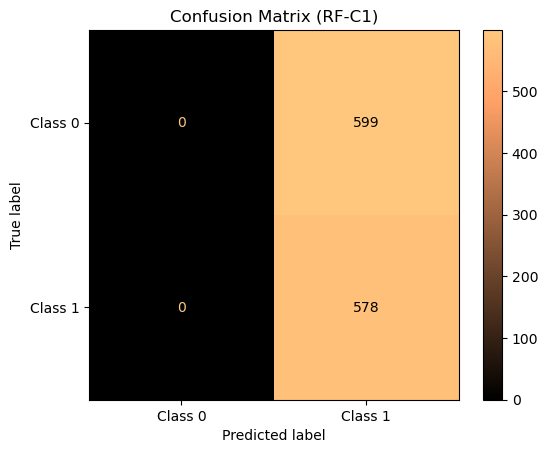

In [ ]:
display = ConfusionMatrixDisplay(confusion_matrix = testing_cm, display_labels = ["Class 0", "Class 1"])
plt.figure(figsize=(10, 10), dpi=150)
display.plot(cmap='copper')
plt.title("Confusion Matrix (RF-C1)")
plt.show()

In [ ]:
# ROC Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction_rfC)

# AUC
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

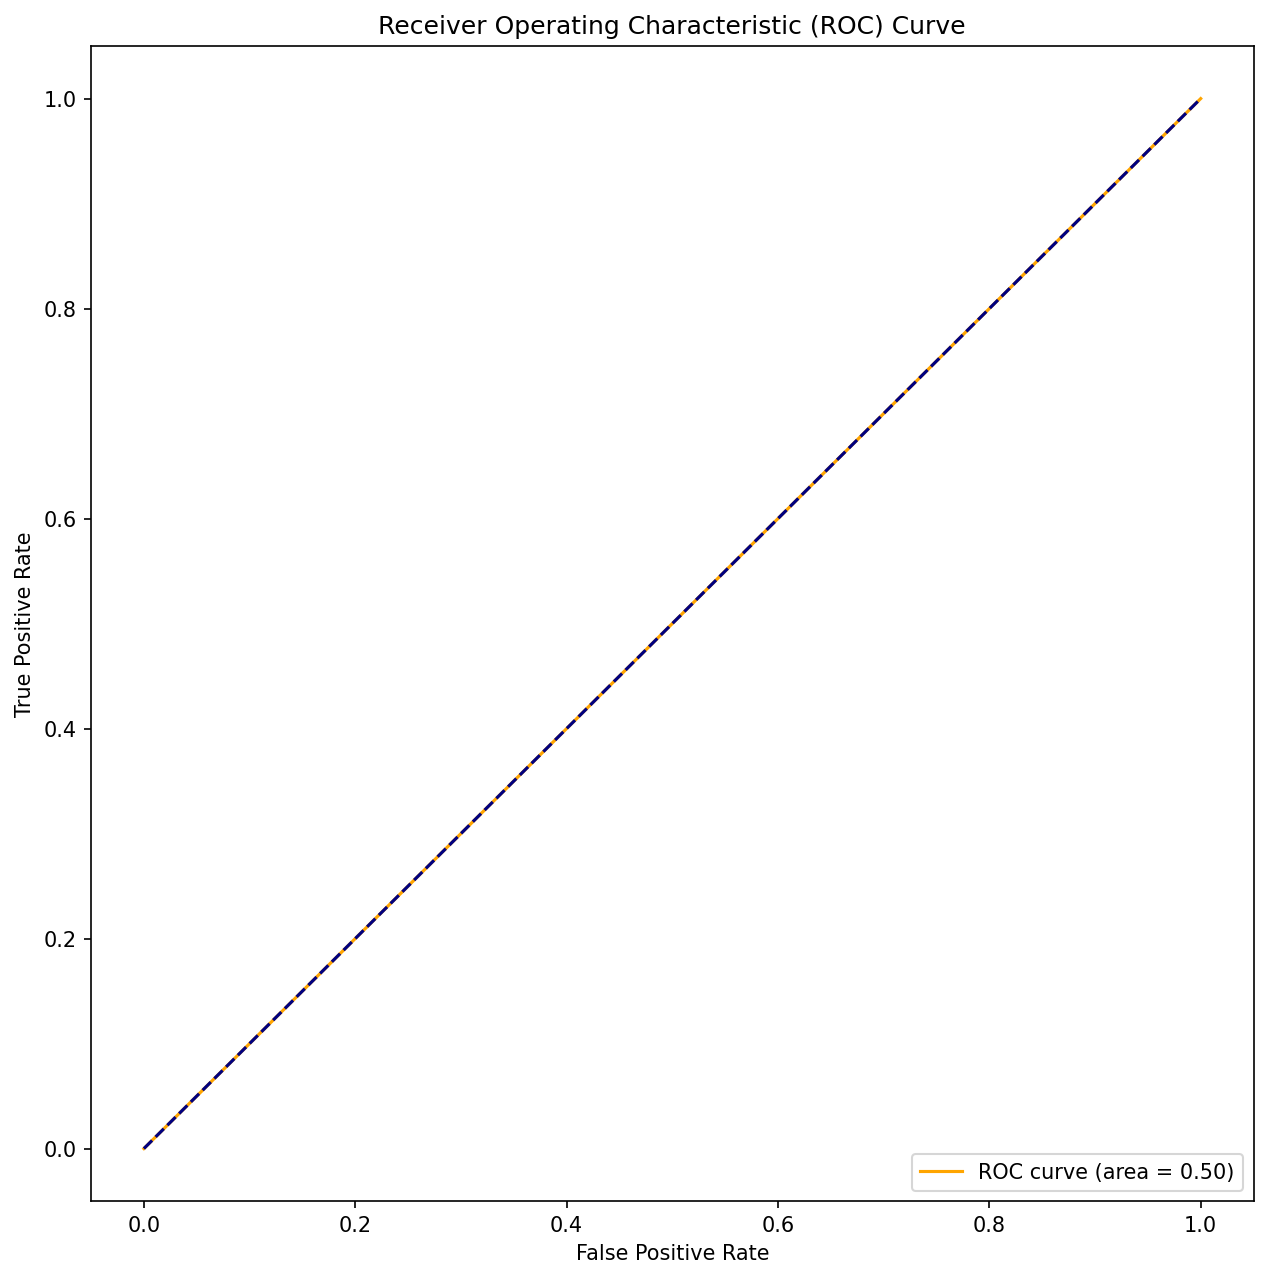

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(10, 10), dpi=150)
plt.plot(false_positive_rate, true_positive_rate, color='orange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Random Forest (Regression)

In [ ]:
df1 = INTC.iloc[:,[0,4]].copy()
df1['Date']=pd.to_datetime(df1['Date'], format='%Y-%m-%d')
df1

,Date,Close
0,2000-01-03,43.500000
1,2000-01-04,41.468750
2,2000-01-05,41.812500
3,2000-01-06,39.375000
4,2000-01-07,41.000000
...,...,...
5885,2023-05-24,29.000000
5886,2023-05-25,27.400000
5887,2023-05-26,29.000000
5888,2023-05-30,29.990000


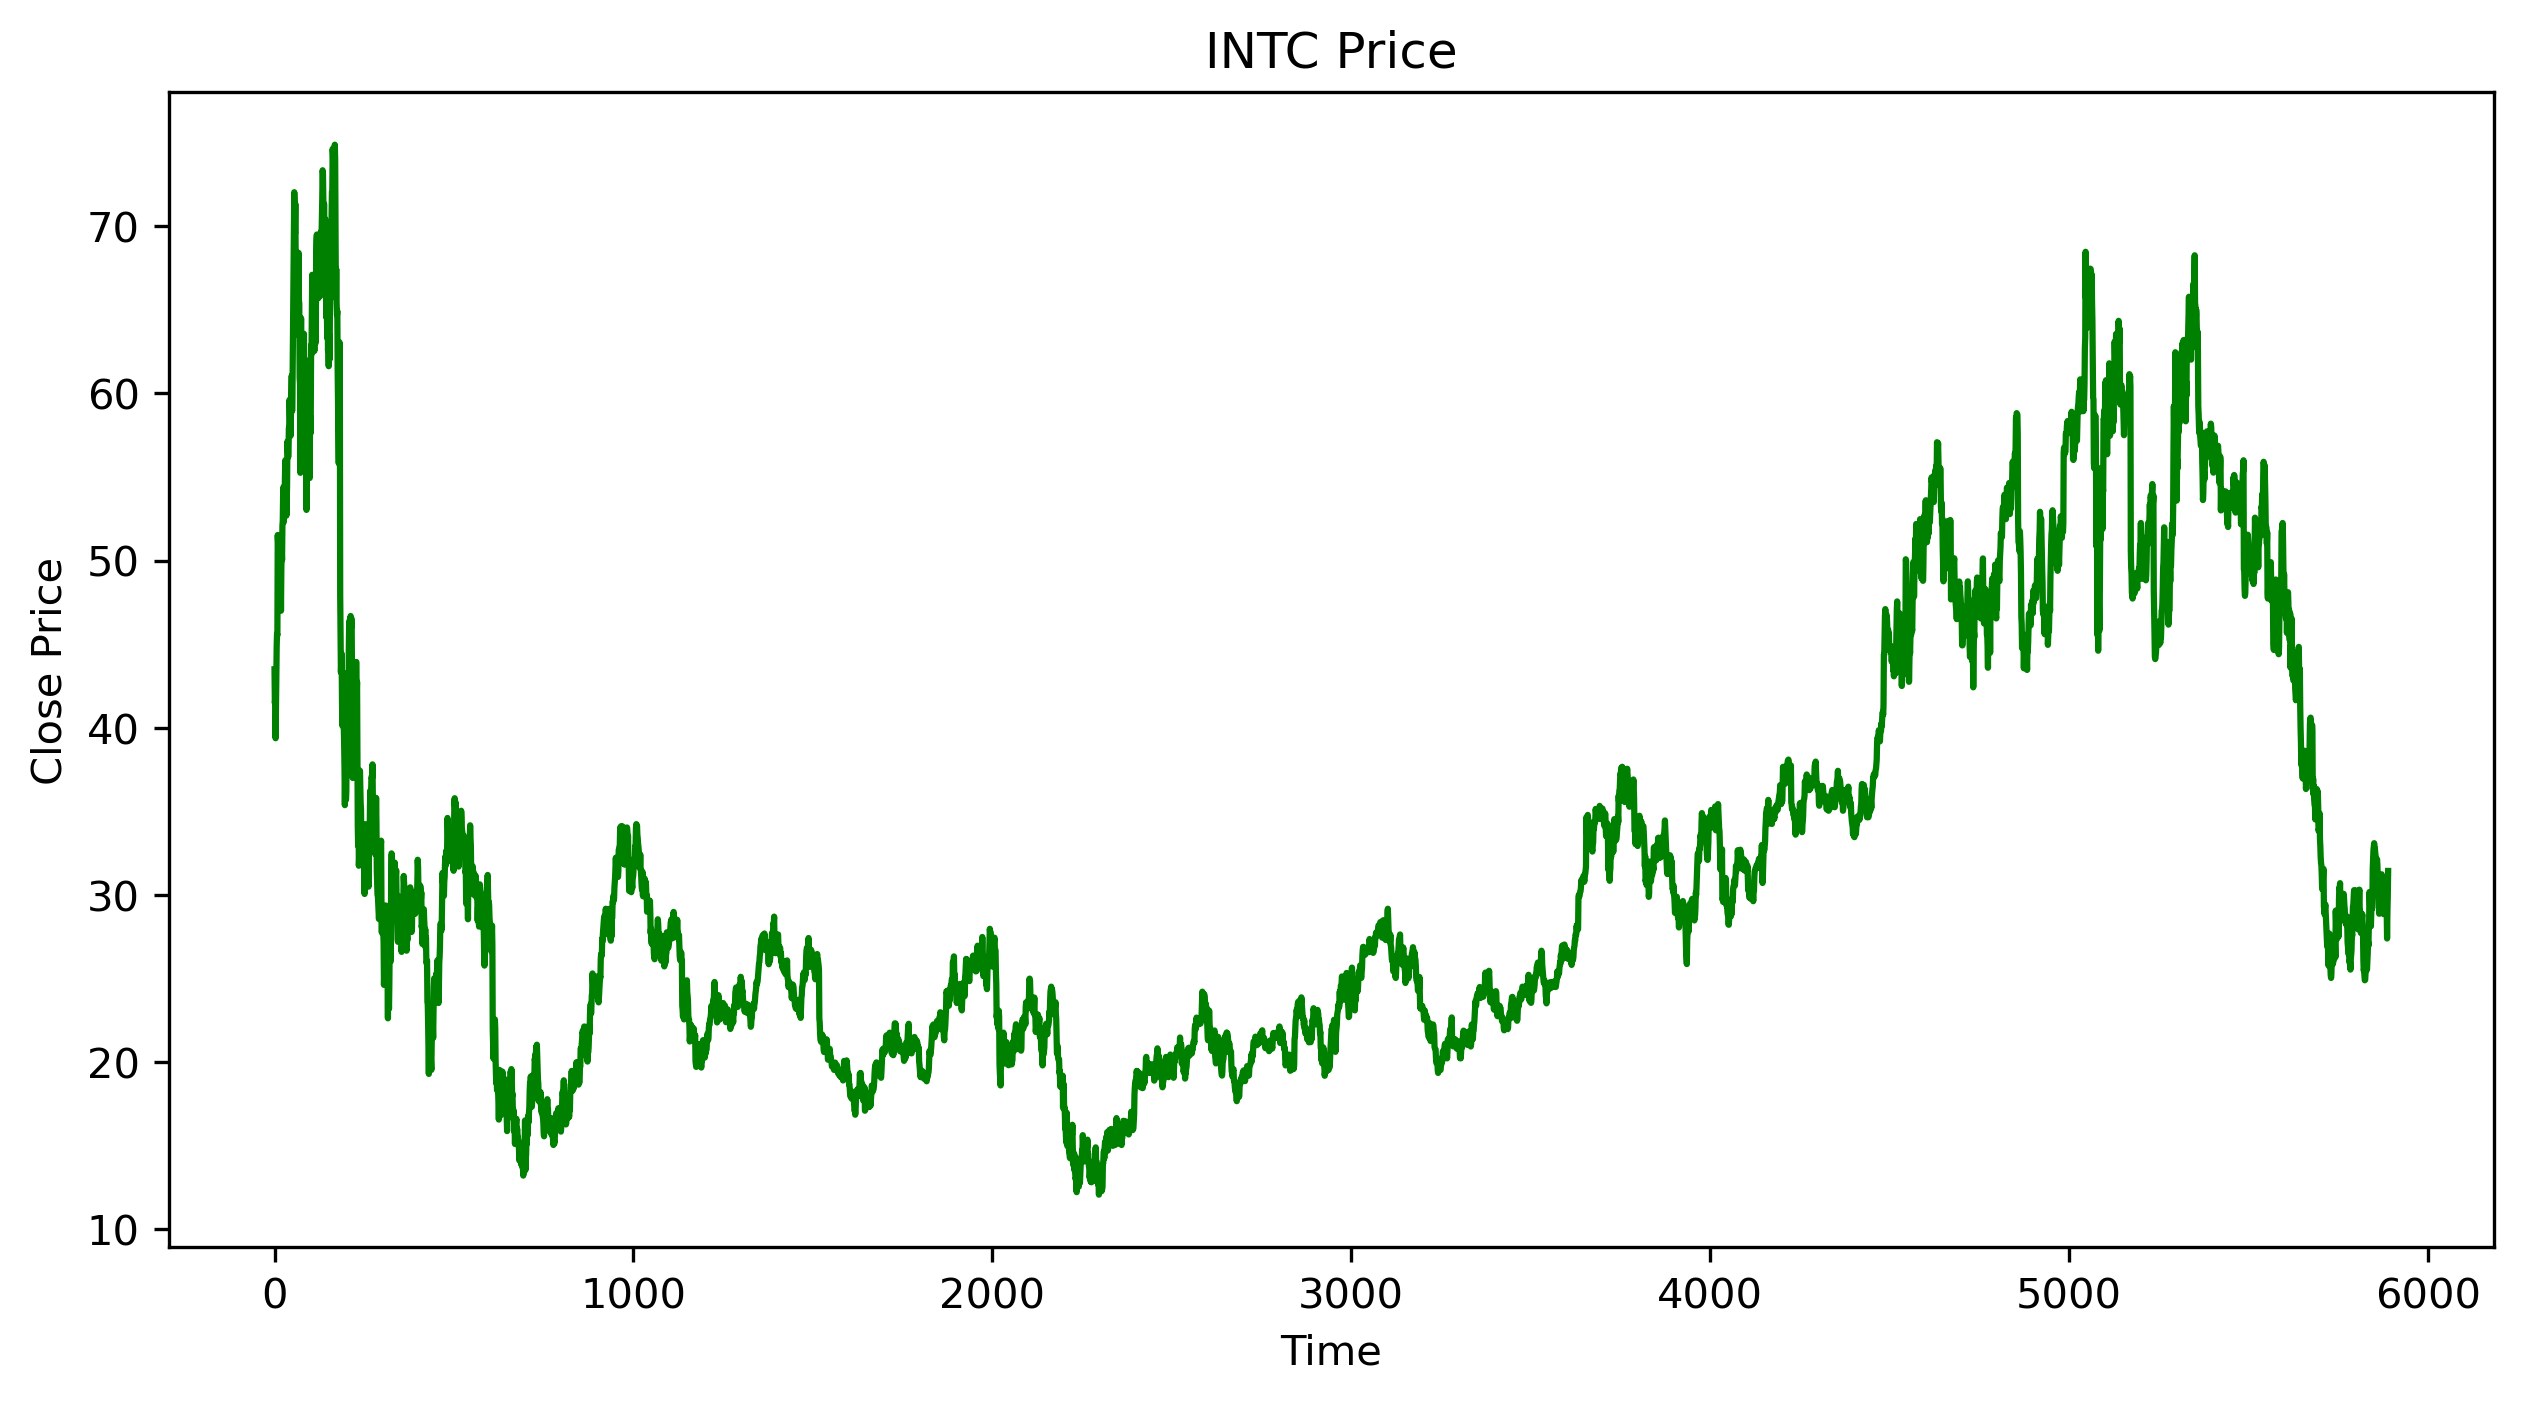

In [ ]:
data3=df1['Close']
plt.figure(figsize=(10,5),dpi=300)
plt.plot(data3, color ='green');
plt.ylabel('Close Price')
plt.title('INTC Price')
plt.xlabel('Time')
plt.show()

In [ ]:
split2 = int(0.8 * data3.shape[0])
Train2, Test2 = data3[0:split], data3[split:]


In [ ]:
Test2

4712    45.910000
4713    45.700001
4714    45.880001
4715    47.290001
4716    46.450001
          ...    
5885    29.000000
5886    27.400000
5887    29.000000
5888    29.990000
5889    31.440001
Name: Close, Length: 1178, dtype: float64

In [ ]:
X_train2 = Train2[:-1].values
y_train2 = Train2[1:].values

X_test2 = Test2[:-1].values
y_test2 = Test2[1:].values

X_train2 = np.reshape(X_train2, (X_train2.shape[0], 1))
X_test2 = np.reshape(X_test2, (X_test2.shape[0], 1))

y_train2 = np.reshape(y_train2, (y_train2.shape[0], 1))
y_test2 = np.reshape(y_test2, (y_test2.shape[0], 1))


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 6)]
max_features = [1, 2, 3]
max_depth = [int(x) for x in np.linspace(1, 6, num = 6)]
max_depth.append(None)
min_samples_split = [8, 10, 12]
min_samples_leaf = [3, 4, 5]
bootstrap = [True, False]

param_grid_RF2 = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap
                 }

print(param_grid_RF2)


{'n_estimators': [100, 120, 140, 160, 180, 200], 'max_features': [1, 2, 3], 'max_depth': [1, 2, 3, 4, 5, 6, None], 'min_samples_split': [8, 10, 12], 'min_samples_leaf': [3, 4, 5], 'bootstrap': [True, False]}


In [ ]:
RF_R = RandomForestRegressor(random_state = 42)
grid_search_RF_R = GridSearchCV(estimator = RF_R, param_grid = param_grid_RF2,
                              cv=5, scoring='neg_mean_absolute_error')


In [ ]:
grid_search_RF_R.fit(X_train2, y_train2.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 2, 3, 4, 5, 6, None],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 120, 140, 160, 180, 200]},
             scoring='neg_mean_absolute_error')

In [ ]:
print("Best Parameters:", grid_search_RF_R.best_params_)
print("Best Score:", grid_search_RF_R.best_score_)

Best Parameters: {'bootstrap': True, 'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
Best Score: -0.7184165306928486


In [ ]:
model_rfR = RandomForestRegressor(max_depth = 6,
                                   n_estimators = 200,
                                   min_samples_leaf = 3,
                                   min_samples_split = 8,
                                   max_features = 1,
                                   bootstrap = True)
model_rfR.fit(X_train2, y_train2.ravel())


/var/folders/rt/4vb6hy993qdchm5xsy2p1_kh0000gn/T/ipykernel_38377/1131502604.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rfR.fit(X_train2, y_train2)


RandomForestRegressor(max_depth=6, max_features=1, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=200)

In [ ]:
prediction_rfR = model_rfR.predict(X_test2)
prediction_rfR.shape

(1177,)

In [ ]:
prediction_rfR

array([46.08077042, 46.07983157, 46.08077042, ..., 27.43085199,
       28.84921243, 30.05820254])

In [ ]:
MAE=mean_absolute_error(y_test2,prediction_rfR)
MSE=mean_squared_error(y_test2,prediction_rfR,squared=True)
RMSE=mean_squared_error(y_test2,prediction_rfR,squared=False)
MAPE=mean_absolute_percentage_error(y_test2,prediction_rfR)
SMAPE=SMAPE_calulate(y_test2,prediction_rfR)
RAE=RAE_calculate(y_test2,prediction_rfR)
MRAE=MRAE_calculate(y_test2,prediction_rfR)
MdRAE=MdRAE_calculate(y_test2,prediction_rfR)
RSE=RSE_calculate(y_test2,prediction_rfR,Root=False)
RRSE=RSE_calculate(y_test2,prediction_rfR,Root=True)

print('MAE:',round(MAE,3)) # Mean Absolute Error 平均絕對誤差
print('MSE:',round(MSE,3)) # Mean Square Error 均方誤差
print('RMSE:',round(RMSE,3)) # Root Mean Squared Error 均方根誤差
print('MAPE:',round(MAPE*100,3),'%') # Mean Absolute Percentage Error 平均絕對百分誤差
print('SMAPE:',round(SMAPE,3),'%') # Symmetric Mean Absolute Percentage Error 對稱性平均絕對百分比誤差
print('RAE:',round(RAE,3)) # Relative Absolute Error 相對絕對誤差
print('MRAE:',MRAE) # Mean Relative Absolute Error
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value

print('RSE:',round(RSE,3)) # Relative Squared Error 相對平方誤差
print('RRSE:',round(RRSE,3))

MAE: 0.845
MSE: 1.608
RMSE: 1.268
MAPE: 1.78 %
SMAPE: 30315.067 %
RAE: 1675.499
MRAE: 1.4235339325245777
MdRAE: 1.328 bench: 48.168
RSE: 1.998
RRSE: 1.414


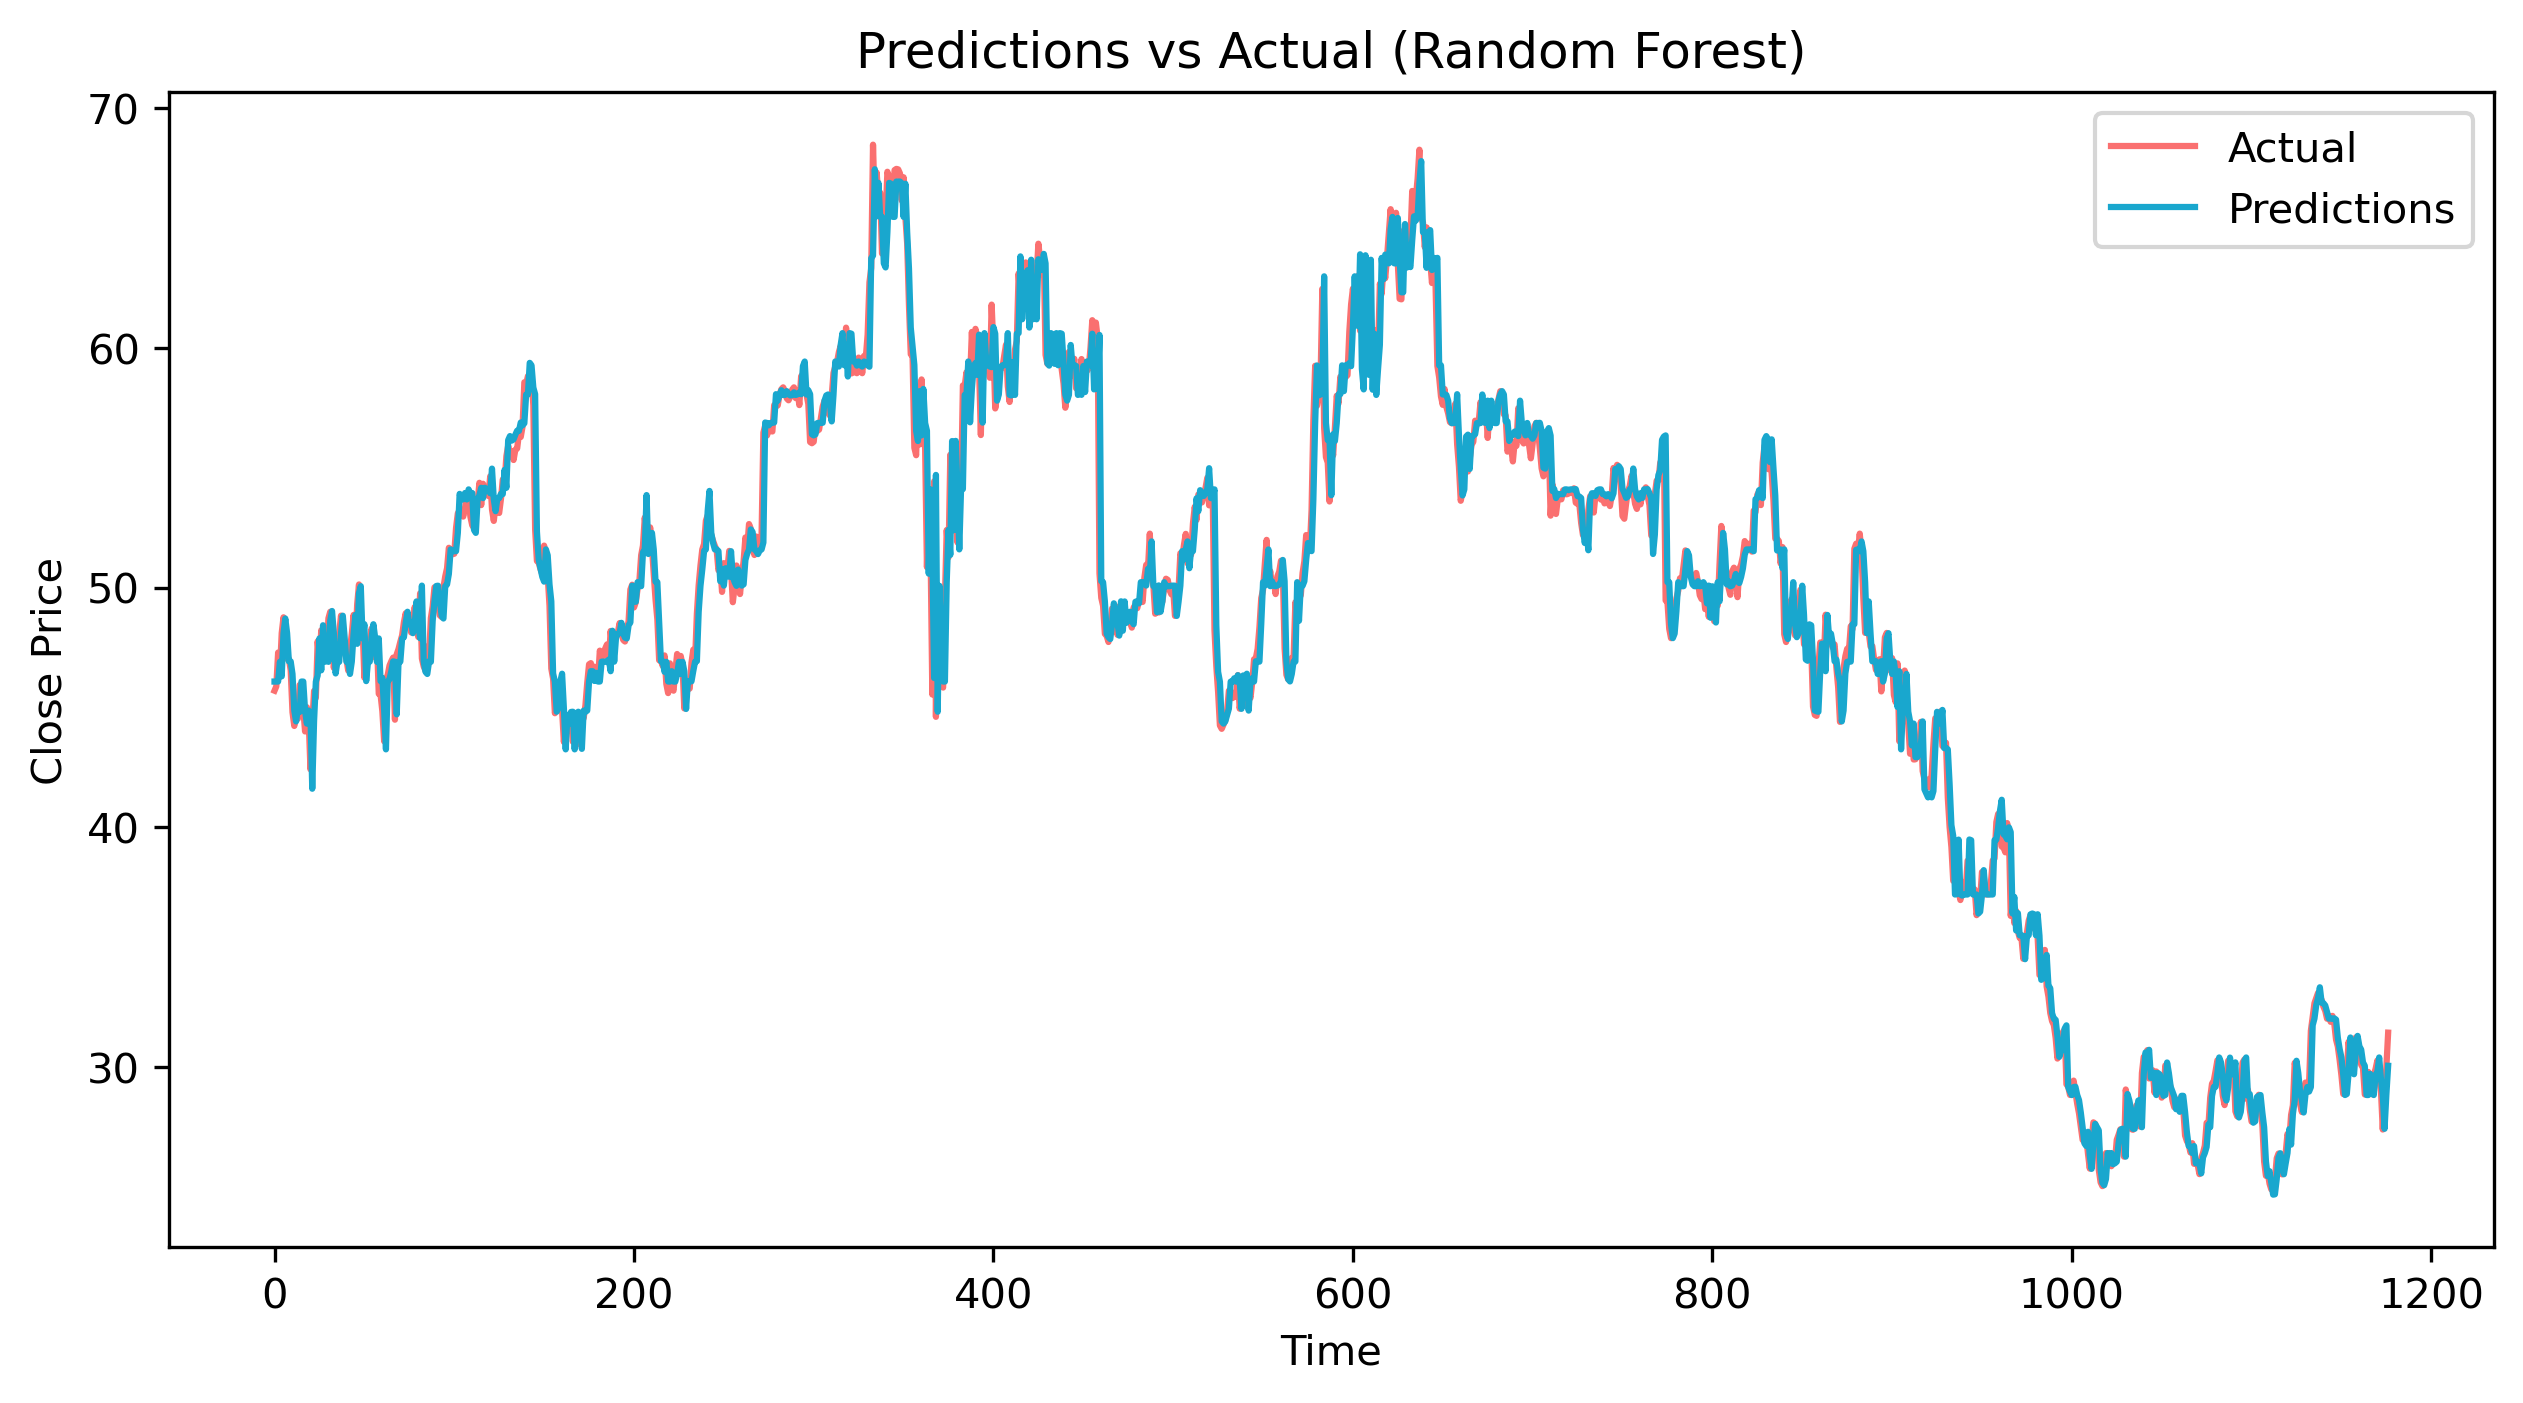

In [ ]:
predictions_f = prediction_rfR.flatten()
y_test_f = y_test2.flatten()

timesteps = range(len(prediction_rfC))

plt.figure(figsize=(10,5),dpi=300)
plt.plot(timesteps, y_test_f, label='Actual', color = '#FA7070')
plt.plot(timesteps, predictions_f, label='Predictions', color = '#19A7CE')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Predictions vs Actual (Random Forest)')

plt.show()